In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./datasets/boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [4]:
df.shape

(2694, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [6]:
df.describe().T

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


#### Percentage of null entries in each column

In [7]:
df.isnull().sum()*100 / df.shape[0]

title                0.000000
domestic_revenue     0.000000
world_revenue        0.000000
distributor          0.000000
opening_revenue     11.284336
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [8]:
df.drop('budget', axis=1, inplace=True)

#### Replace values in columns with the respective column mode (most popular value)

In [9]:
for col in ['MPAA',]:
    df[col] = df[col].fillna(df[col].mode()[0])

#### Dropna remaining nulls

In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

title               0
domestic_revenue    0
world_revenue       0
distributor         0
opening_revenue     0
opening_theaters    0
MPAA                0
genres              0
release_days        0
dtype: int64

In [12]:
df['domestic_revenue'].head()

0    $620,181,382
1    $226,008,385
2    $412,563,408
3    $389,813,101
4    $504,014,165
Name: domestic_revenue, dtype: object

In [13]:
for col in ['domestic_revenue', 'opening_revenue', 'world_revenue']:
    df[col] = df[col].str[1:]
# df['domestic_revenue'] = df['domestic_revenue'].str[1:]

In [14]:
df['opening_revenue'].head()

0    220,009,584
1     98,786,705
2    103,251,471
3    146,510,104
4    174,750,616
Name: opening_revenue, dtype: object

In [15]:
for col in ['domestic_revenue', 'opening_revenue', 'world_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].str.replace(',', '')

    # Selecting rows with no null values
    # in the columns on which we are iterating.
    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float)
 
    df[col] = pd.to_numeric(df[col], errors='coerce')

### EDA

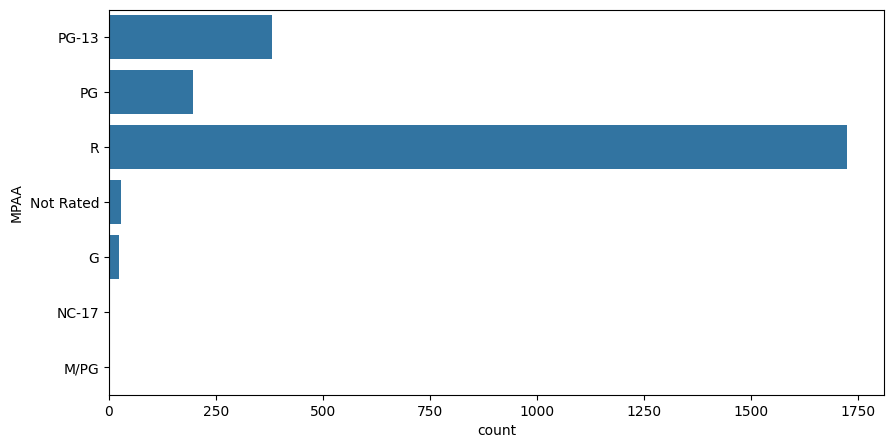

In [16]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

In [18]:
df.groupby('MPAA')['domestic_revenue'].mean()

MPAA
G            3.539276e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    4.897703e+05
PG           5.379622e+07
PG-13        5.891966e+07
R            6.689533e+06
Name: domestic_revenue, dtype: float64

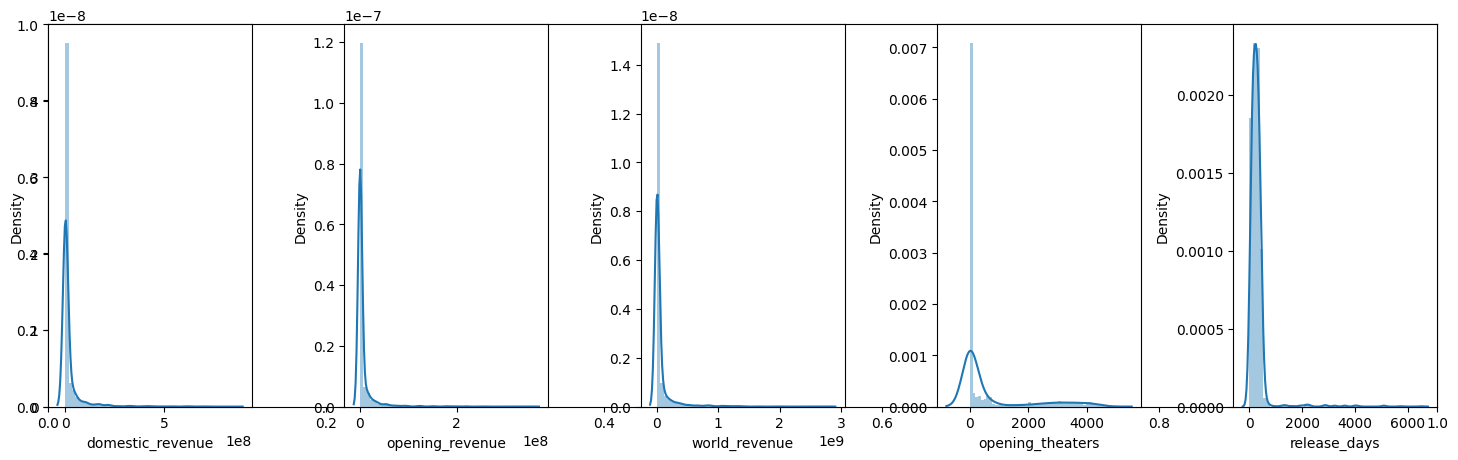

In [22]:
plt.subplots(figsize=(15, 5))
 
features = ['domestic_revenue', 'opening_revenue', 'world_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 5, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

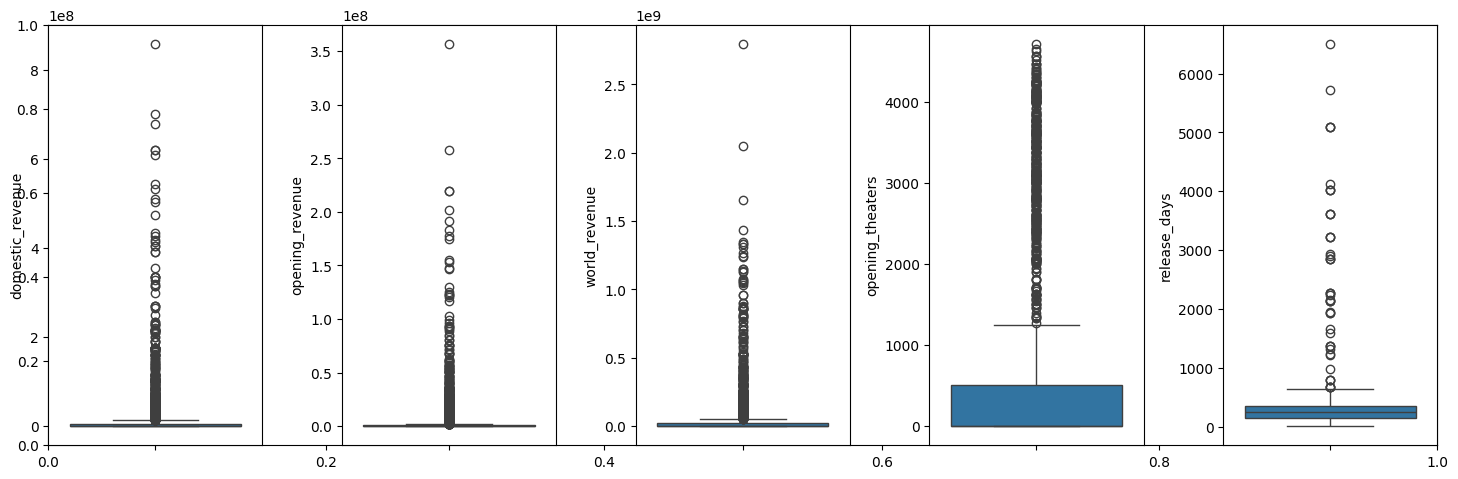

In [23]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 5, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()

### There are a lot of outliers in the data, let's try turning some values to a log scale

In [25]:
data_copy = df.copy() #backup the dataframe before log

In [26]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

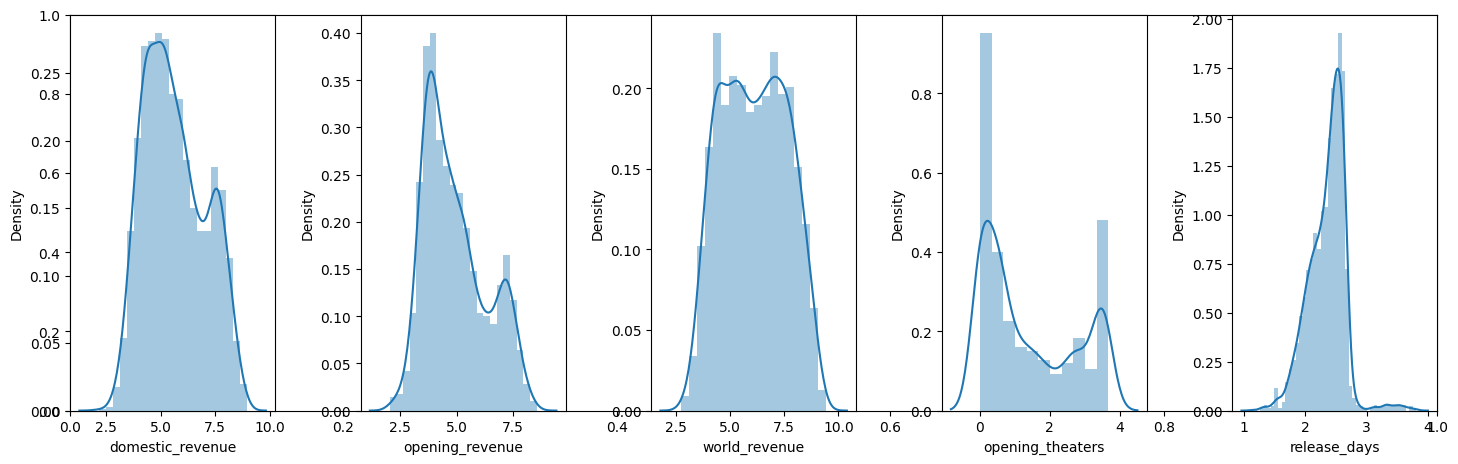

In [27]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 5, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

### Generating features etc

#### Splitting genres with a vectorizer and putting them into separate columns
essentially one-hot encode genres from a list-style column

In [28]:
df['genres'].head()

0        Action,Adventure,Fantasy,Sci-Fi
1              Action,Adventure,Thriller
2    Action,Adventure,Fantasy,Sci-Fi,War
3         Action,Adventure,Comedy,Sci-Fi
4         Family,Fantasy,Musical,Romance
Name: genres, dtype: object

In [30]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()
 
genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
    df[name] = features[:, i]
 
df.drop('genres', axis=1, inplace=True)

In [31]:
df.columns

Index(['title', 'domestic_revenue', 'world_revenue', 'distributor',
       'opening_revenue', 'opening_theaters', 'MPAA', 'release_days', 'action',
       'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fi', 'film', 'history',
       'horror', 'music', 'musical', 'mystery', 'news', 'noir', 'reality',
       'romance', 'sci', 'short', 'sport', 'thriller', 'tv', 'war', 'western'],
      dtype='object')

In [32]:
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,MPAA,release_days,action,adult,...,noir,reality,romance,sci,short,sport,thriller,tv,war,western
0,Star Wars: Episode VIII - The Last Jedi,8.792519,9.124680,Walt Disney Studios Motion Pictures,8.342442,3.626546,PG-13,2.582063,1,0,...,0,0,0,1,0,0,0,0,0,0
1,The Fate of the Furious,8.354125,9.092020,Universal Pictures,7.994698,3.634477,PG-13,2.418301,1,0,...,0,0,0,0,0,0,1,0,0,0
2,Wonder Woman,8.615491,8.914791,Warner Bros.,8.013896,3.619615,PG-13,2.336460,1,0,...,0,0,0,1,0,0,0,0,1,0
3,Guardians of the Galaxy Vol. 2,8.590856,8.936391,Walt Disney Studios Motion Pictures,8.165868,3.638190,PG-13,2.382017,1,0,...,0,0,0,1,0,0,0,0,0,0
4,Beauty and the Beast,8.702443,9.101583,Walt Disney Studios Motion Pictures,8.242419,3.624282,PG,2.462398,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Additional removing

In [33]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:
 
    # Removing columns having more
    # than 95% of the values as zero.
    if (df[col] == 0).mean() > 0.95:
        removed += 1
        df.drop(col, axis=1, inplace=True)
 
print(removed)
print(df.shape)

11
(2356, 26)


#### Label encoding

In [34]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [36]:
corr_df = df.drop(['title',], axis=1)

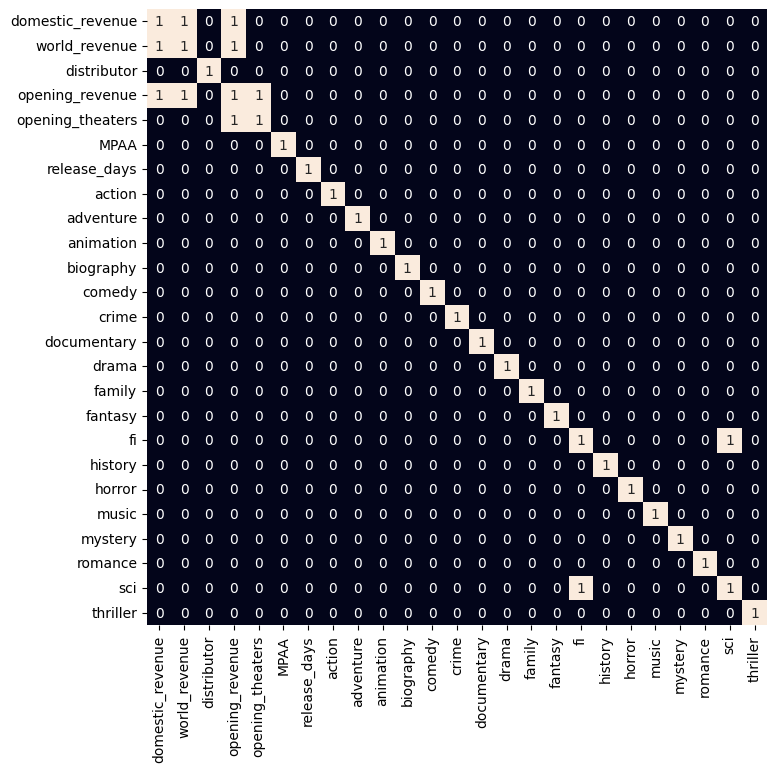

In [37]:
plt.figure(figsize=(8, 8))
sb.heatmap(corr_df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

### Model development, splitting into features and target etc

In [38]:
features = df.drop(['title', 'domestic_revenue', 'fi'], axis=1)
target = df['domestic_revenue'].values
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((2120, 23), (236, 23))

In [39]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### XGBoost

In [40]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))
 
val_preds = model.predict(X_val)
print('Validation Error : ', mae(Y_val, val_preds))
print()

Training Error :  0.026207925647540795
Validation Error :  0.1419302878829778

